# 07 Nearest neighborhood and tree analysis
---

**Author:** Chen Weng

**Date:** August 14, 2024

## Description
Use redeem filter-2 for combine BMMC and HSPC, followed by nearest neighborhood analysis and the tree analysis

---

# Load packages and define function

In [2]:
library(dplyr)
library(redeemR)
library(ggplot2)
library(gridExtra)
library(data.table)
library(Matrix)
library(Matrix.utils)

In [4]:
source("../utils/utils.r")

In [83]:
neighborhood_analysis_v2<-function(d.w_jaccard.edge6,d.w_jaccard,k=15){
median_neighbor_idx<-c()
median_neighbor_idx_random<-c()
for(i in 1:ncol(d.w_jaccard.edge6)){
    cur.cell<-row.names(d.w_jaccard.edge6)[i]
    x<-d.w_jaccard.edge6[i,] %>% .[order(.)] %>% .[1:k] %>% names 
    neighbors<-setdiff(x,cur.cell)
    median_dist<-d.w_jaccard[i,] %>% .[order(.)] %>% rank %>% .[neighbors] %>% median 
    median_dist.random.3times<-c()
    for (j in 1:2){   
    x.random<-d.w_jaccard.edge6[i,] %>% .[order(.)] %>% .[sample(1:ncol(d.w_jaccard.edge6),k)] %>% names
    neighbors.random<-setdiff(x.random,cur.cell)
    median_dist.random<-d.w_jaccard[i,] %>% .[order(.)] %>% rank %>% .[neighbors.random] %>% median
    # print(paste("median_dist.random",median_dist.random))
    median_dist.random.3times <-c(median_dist.random.3times,median_dist.random)
    }
    median_dist.random.mean <- mean(median_dist.random.3times)
    # print(paste("median_dist.random.mean",median_dist.random.mean))

    median_neighbor_idx<-c(median_neighbor_idx,median_dist)
    median_neighbor_idx_random<-c(median_neighbor_idx_random,median_dist.random.mean)
    }
    return(list(median_neighbor_idx=median_neighbor_idx,median_neighbor_idx_random=median_neighbor_idx_random))
}

#### 2024-8-13 add functions for notebook 07_nearest_neighbor_tree 
## Function to collect mutations, 
## here we remove 72_T_C and 10810_T_C because it is near homoplasmy in Old2,  we remove 309_C_T becasue this is a highly varibale region
## These criteria is somewhat redundant with D-loop and hypermutable 
collect_mutations <- function(redeem, blacklist=c("72_T_C", "10810_T_C","309_C_T")){
    var_pass<-redeem@V.fitered %>% subset(.,HomoTag == "Hetero" & label != "hyper" & Dloop!="D-loop" & !Variants %in% blacklist) %>% .$Variants
    var_collections <- list(var_pass=var_pass)
    return(var_collections)
}

## functions to get filtered matrix for downstream analysis
filter_matrix <- function(mtx.bi, var_pass){
    mtx.bi.pass<- mtx.bi[,which(colnames(mtx.bi) %in% convert_variant(var_pass))]
    mtx.bi.pass<-mtx.bi.pass[rowSums(mtx.bi.pass)>=2,]
    return(mtx.bi.pass)
}

## prepare a list of functions if there is a list of mutations
Make_mtx_for_collection <- function(mtx.bi, collection){
mtx.bi.list<-list()
    for (i in 1:length(collection)){
        mtx.bi.filtered<- filter_matrix(mtx.bi, collection[[i]])
        mtx.bi.list <-c(mtx.bi.list,list(mtx.bi.filtered))
    }
    names(mtx.bi.list) <- names(collection)
    return(mtx.bi.list)
}


## Compute adjacency matrix
CountOverlap<-function(M){
    require(Matrix)
    a <- M %*% Matrix::t(M)
    return(a)
}

## function to benchmark the mutation matrix
## 1, number of cells connected for each given cell (median)
## 2, number of mutations per cell
## 3, number of cells per mut
benchmark_matix_for_collection<- function(mtx.bi.list){
median_connected <- c()
mut_per_cell <- c()
cell_per_mut <- c()
    for (i in 1: length(mtx.bi.list)){
        mtx.bi <- mtx.bi.list[[i]]
        cell_connected<-CountOverlap(mtx.bi)
        diag(cell_connected)<-0
        median_connected<- c(median_connected, median(apply(cell_connected,1,function(x){sum(x>=1)})))
        mut_per_cell<- c(mut_per_cell,median(rowSums(mtx.bi)))
        cell_per_mut<- c(cell_per_mut,median(colSums(mtx.bi)))
    }
report<-list(names=names(mtx.bi.list),median_connected=median_connected, mut_per_cell=mut_per_cell, cell_per_mut=cell_per_mut)
return(report)   
}

## compute cell-cell distance
get_distances_for_collection <- function(mtx.bi.list){
distances.list <- list()
    for (i in 1: length(mtx.bi.list)){
      d<-get_dist(mtx.bi.list[[i]]) %>% as.matrix
      distances.list <- c(distances.list,list(d))
    }
names(distances.list) <- names(mtx.bi.list)
return(distances.list)
}

compare_neighborhood <- function(mtx1, mtx2, k){
row.names(mtx1)<-gsub("_",".", row.names(mtx1))
cell_names_shared<- intersect(row.names(mtx1), row.names(mtx2))
mtx1 <- mtx1[cell_names_shared,]
mtx2 <- mtx2[cell_names_shared,]
jaccard.1 <- get_dist(mtx1) %>% as.matrix
jaccard.2 <- get_dist(mtx2) %>% as.matrix 
neighbor.result<-neighborhood_analysis_v2(jaccard.2,jaccard.1,k=k)
return(neighbor.result)
}

save_for_distances <- function(outputpath, distance.list, main){
    for (i in 1:length(distance.list)){
        saveRDS(distance.list[[i]], paste0(outputpath, main, ".", names(distance.list)[i],".rds"))
    }
    
}

read_tree_collections <- function(group){
#groups <- c("hyper", "lmhc", "lmhc_hyper", "hyper_dloopb")
trees <- list() 
for (sample in samples){
    path <- paste0(WD, sample, "_BMMC_HSPC_distance.var_pass.",group,".njtree.rds")
    tree<-readRDS(path)
    trees <- c(trees, list(tree))
}
names(trees) <- samples
return(trees)
}

plot_tree_collection <- function(trees, main){
plots<-list()
for (i in 1:length(trees)){
    p<-ggtree(trees[[i]], branch.length='none',layout="circular")+ggtitle(paste0(names(trees)[i], main))
    plots<-c(plots, list(p))
}
return(plots)
}

# Load data

<span style="color: blue;"> Load combined redeem object after trimming (5bp) and binomial cleaning (FDR < 0.05)</br>

In [84]:
dir <- "../output/"  ## or PathToClonedReproducibleGitHub/output
Old1_BMMC_HSPC_trim5.binom.redeem<-readRDS(paste0(dir,"combine_redeem_trim5.binomOld1_BMMC_HSPC.rds"))
Old2_BMMC_HSPC_trim5.binom.redeem<-readRDS(paste0(dir,"combine_redeem_trim5.binomOld2_BMMC_HSPC.rds"))
Young1_BMMC_HSPC_trim5.binom.redeem<-readRDS(paste0(dir,"combine_redeem_trim5.binomYoung1_BMMC_HSPC.rds"))
Young2_BMMC_HSPC_trim5.binom.redeem<-readRDS(paste0(dir,"combine_redeem_trim5.binomYoung2_BMMC_HSPC.rds"))

> These redeem objects are generated by `../runscript/process_BMMC_HPC.r`

<span style="color: blue;"> Load seperate data</br>
Not used in latest version

In [85]:
## Read in the 4 donors BMMC
sensitve.raw.y1<-read.table("/lab/solexa_weissman/cweng/Projects/Collaborator/Caleb/position_bias/Young1.T1.BMMC.Consensus.final/RawGenotypes.Sensitive.StrandBalance")
sensitve.raw.y2<-read.table("/lab/solexa_weissman/cweng/Projects/Collaborator/Caleb/position_bias/Young2.BMMC.Consensus.final/RawGenotypes.Sensitive.StrandBalance")
sensitve.raw.o1<-read.table("/lab/solexa_weissman/cweng/Projects/Collaborator/Caleb/position_bias/Old1.BMMC.Consensus.final/RawGenotypes.Sensitive.StrandBalance")
sensitve.raw.o2<-read.table("/lab/solexa_weissman/cweng/Projects/Collaborator/Caleb/position_bias/Old2.BMMC.Consensus.final/RawGenotypes.Sensitive.StrandBalance")

In [ ]:
## Read in the 4 donor HPC
Dir="/lab/solexa_weissman/cweng/Projects/MitoTracing_Velocity/SecondaryAnalysis/reproducibility_pub/data/redeemV_final/"
sensitve.raw.y1.HPC<-read.table(paste(Dir,"Young1.T1.HPC.Consensus.final/RawGenotypes.Sensitive.StrandBalance",sep=""))  
sensitve.raw.y2.HPC<-read.table(paste(Dir,"Young2.HPC.Consensus.final/RawGenotypes.Sensitive.StrandBalance",sep="")) 
sensitve.raw.o1.HPC<-read.table(paste(Dir,"Old1.HSPC.Consensus.final/RawGenotypes.Sensitive.StrandBalance",sep="")) 
sensitve.raw.o2.HPC<-read.table(paste(Dir,"Old2.HSPC.Consensus.final/RawGenotypes.Sensitive.StrandBalance",sep=""))

<span style="color: blue;"> Load the original redeem data </br>

In [ ]:
Old1_BMMC_HSPC_mitoTracing.sensitive_JACnj<-readRDS("/lab/solexa_weissman/cweng/Projects/MitoTracing_Velocity/SecondaryAnalysis/Old1Old2/RDS/Old1_BMMC_HSPC_mitoTracing.sensitive_JACnj_Vassigned_p") %>% convert_mitotracing_redeemR()
Old2_BMMC_HSPC_mitoTracing.sensitive_JACnj<-readRDS("/lab/solexa_weissman/cweng/Projects/MitoTracing_Velocity/SecondaryAnalysis/Old1Old2/RDS/Old2_BMMC_HSPC_mitoTracing.sensitive_JACnj_Vassigned_p") %>% convert_mitotracing_redeemR()
Young1_BMMC_HSPC_mitoTracing.sensitive_JACnj<-readRDS("/lab/solexa_weissman/cweng/Projects/MitoTracing_Velocity/SecondaryAnalysis/Old1Old2/RDS/DN4_BMMC_HSPC_mitoTracing.sensitive_JACnj_Vassigned_p") %>% convert_mitotracing_redeemR()
Young2_BMMC_HSPC_mitoTracing.sensitive_JACnj<-readRDS("/lab/solexa_weissman/cweng/Projects/MitoTracing_Velocity/SecondaryAnalysis/Old1Old2/RDS/DN9_BMMC_HSPC_mitoTracing.sensitive_JACnj_Vassigned_p") %>% convert_mitotracing_redeemR()

<span style="color: blue;"> Load the original redeem data </br>

In [ ]:
Old1_BMMC_HSPC_mitoTracing.sensitive_JACnj<-readRDS("/lab/solexa_weissman/cweng/Projects/MitoTracing_Velocity/SecondaryAnalysis/Old1Old2/RDS/Old1_BMMC_HSPC_mitoTracing.sensitive_JACnj_Vassigned_p") %>% convert_mitotracing_redeemR()
Old2_BMMC_HSPC_mitoTracing.sensitive_JACnj<-readRDS("/lab/solexa_weissman/cweng/Projects/MitoTracing_Velocity/SecondaryAnalysis/Old1Old2/RDS/Old2_BMMC_HSPC_mitoTracing.sensitive_JACnj_Vassigned_p") %>% convert_mitotracing_redeemR()
Young1_BMMC_HSPC_mitoTracing.sensitive_JACnj<-readRDS("/lab/solexa_weissman/cweng/Projects/MitoTracing_Velocity/SecondaryAnalysis/Old1Old2/RDS/DN4_BMMC_HSPC_mitoTracing.sensitive_JACnj_Vassigned_p") %>% convert_mitotracing_redeemR()
Young2_BMMC_HSPC_mitoTracing.sensitive_JACnj<-readRDS("/lab/solexa_weissman/cweng/Projects/MitoTracing_Velocity/SecondaryAnalysis/Old1Old2/RDS/DN9_BMMC_HSPC_mitoTracing.sensitive_JACnj_Vassigned_p") %>% convert_mitotracing_redeemR()

<span style="color: blue;"> Load combined data</br>
Not used in latest version

In [ ]:
## Convert to redeemR 
DN4_BMMC_HSPC_redeemr.sensitive_JACnj<-convert_mitotracing_redeemR(DN4_BMMC_HSPC_mitoTracing.sensitive_JACnj)
DN9_BMMC_HSPC_redeemr.sensitive_JACnj<-convert_mitotracing_redeemR(DN9_BMMC_HSPC_mitoTracing.sensitive_JACnj)
Old1_BMMC_HSPC_redeemr.sensitive_JACnj<-convert_mitotracing_redeemR(Old1_BMMC_HSPC_mitoTracing.sensitive_JACnj)
Old2_BMMC_HSPC_redeemr.sensitive_JACnj<-convert_mitotracing_redeemR(Old2_BMMC_HSPC_mitoTracing.sensitive_JACnj)

<span style="color: red;"> We also provide a new tutorial two integrate multiple runs of redeem experiments with trimming and binomial cleaning on Github(a link?)</br>

# Examine the redeem data quality </br>

<span style="color: blue;"> Add transition/transversion to each combined redeem object </br>

In [11]:
Young1_BMMC_HSPC_trim5.binom.redeem <- add_mutation_type(Young1_BMMC_HSPC_trim5.binom.redeem)
Young2_BMMC_HSPC_trim5.binom.redeem <- add_mutation_type(Young2_BMMC_HSPC_trim5.binom.redeem)
Old1_BMMC_HSPC_trim5.binom.redeem <- add_mutation_type(Old1_BMMC_HSPC_trim5.binom.redeem)
Old2_BMMC_HSPC_trim5.binom.redeem <- add_mutation_type(Old2_BMMC_HSPC_trim5.binom.redeem)

Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”


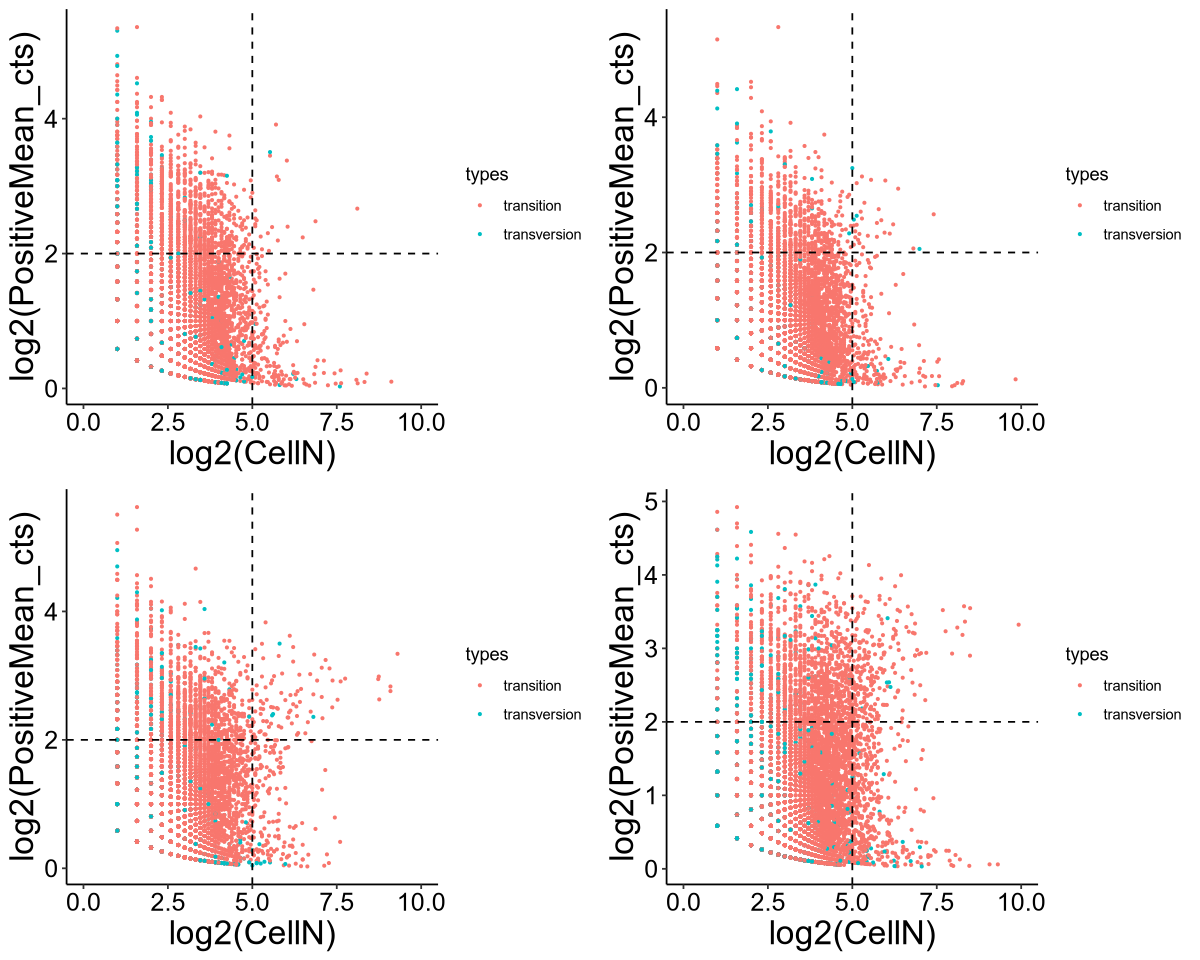

In [13]:
p1<-ggplot(Young1_BMMC_HSPC_trim5.binom.redeem@V.fitered)+aes(log2(CellN),log2(PositiveMean_cts), color= types)+geom_point(size=0.5)+xlim(0, 10)+theme_cw1()+geom_vline(xintercept = 5, linetype=2)+geom_hline(yintercept = 2, linetype=2)
p2<-ggplot(Young2_BMMC_HSPC_trim5.binom.redeem@V.fitered)+aes(log2(CellN),log2(PositiveMean_cts), color= types)+geom_point(size=0.5)+xlim(0, 10)+theme_cw1()+geom_vline(xintercept = 5, linetype=2)+geom_hline(yintercept = 2, linetype=2)
p3<-ggplot(Old1_BMMC_HSPC_trim5.binom.redeem@V.fitered)+aes(log2(CellN),log2(PositiveMean_cts), color= types)+geom_point(size=0.5)+xlim(0, 10)+theme_cw1()+geom_vline(xintercept = 5, linetype=2)+geom_hline(yintercept = 2, linetype=2)
p4<-ggplot(Old2_BMMC_HSPC_trim5.binom.redeem@V.fitered)+aes(log2(CellN),log2(PositiveMean_cts), color= types)+geom_point(size=0.5)+xlim(0, 10)+theme_cw1()+geom_vline(xintercept = 5, linetype=2)+geom_hline(yintercept = 2, linetype=2)
options(repr.plot.width = 10, repr.plot.height = 8, repr.plot.res = 120)
grid.arrange(p1,p2,p3,p4,nrow=2)

The majority of mutation calls are true signals (transition)

In [14]:
print(paste0("Young1_BMMC_HSPC: fraction of transition: ",with(Young1_BMMC_HSPC_trim5.binom.redeem@V.fitered, sum(types=="transition")/length(types))))
print(paste0("Young2_BMMC_HSPC: fraction of transition: ",with(Young2_BMMC_HSPC_trim5.binom.redeem@V.fitered, sum(types=="transition")/length(types))))
print(paste0("Old1_BMMC_HSPC: fraction of transition: ",with(Old1_BMMC_HSPC_trim5.binom.redeem@V.fitered, sum(types=="transition")/length(types))))
print(paste0("Old2_BMMC_HSPC: fraction of transition: ",with(Old2_BMMC_HSPC_trim5.binom.redeem@V.fitered, sum(types=="transition")/length(types))))

[1] "Young1_BMMC_HSPC: fraction of transition: 0.924176398814711"
[1] "Young2_BMMC_HSPC: fraction of transition: 0.92885440739518"
[1] "Old1_BMMC_HSPC: fraction of transition: 0.907923930269414"
[1] "Old2_BMMC_HSPC: fraction of transition: 0.890705458290422"


# Downstream analysis

<span style="color: blue;"> Mutation annotation (`add_hypermutable`) </br>
- dloop (defined as  1-583 and 16190-16569)
- empirical hypermutable mutations(If a mutation appear > 0.5% in 3 young and 2 aged donors) 


In [15]:
Young1_BMMC_HSPC_trim5.binom.redeem <- add_hypermutable(Young1_BMMC_HSPC_trim5.binom.redeem)
Young2_BMMC_HSPC_trim5.binom.redeem <- add_hypermutable(Young2_BMMC_HSPC_trim5.binom.redeem)
Old1_BMMC_HSPC_trim5.binom.redeem <- add_hypermutable(Old1_BMMC_HSPC_trim5.binom.redeem)
Old2_BMMC_HSPC_trim5.binom.redeem <- add_hypermutable(Old2_BMMC_HSPC_trim5.binom.redeem)

<span style="color: blue;"> Collect informative mutations by removing blacklist and hypermutable region </br>

In [16]:
Young1_BMMC_HSPC.collection<-collect_mutations(Young1_BMMC_HSPC_trim5.binom.redeem, blacklist = c("72_T_C", "10810_T_C", "309_C_T"))
Young2_BMMC_HSPC.collection<-collect_mutations(Young2_BMMC_HSPC_trim5.binom.redeem, blacklist = c("72_T_C", "10810_T_C", "309_C_T"))
Old1_BMMC_HSPC.collection<-collect_mutations(Old1_BMMC_HSPC_trim5.binom.redeem, blacklist = c("72_T_C", "10810_T_C", "309_C_T"))
Old2_BMMC_HSPC.collection<-collect_mutations(Old2_BMMC_HSPC_trim5.binom.redeem, blacklist = c("72_T_C", "10810_T_C", "309_C_T"))


<span style="color: blue;"> Extract the informative binary matrix from redeeem </br>

In [17]:
Young1_BMMC_HSPC.mtx.bi.list<- Make_mtx_for_collection(Young1_BMMC_HSPC_trim5.binom.redeem@Cts.Mtx.bi,Young1_BMMC_HSPC.collection)
Young2_BMMC_HSPC.mtx.bi.list<- Make_mtx_for_collection(Young2_BMMC_HSPC_trim5.binom.redeem@Cts.Mtx.bi,Young2_BMMC_HSPC.collection)
Old1_BMMC_HSPC.mtx.bi.list<- Make_mtx_for_collection(Old1_BMMC_HSPC_trim5.binom.redeem@Cts.Mtx.bi,Old1_BMMC_HSPC.collection)
Old2_BMMC_HSPC.mtx.bi.list<- Make_mtx_for_collection(Old2_BMMC_HSPC_trim5.binom.redeem@Cts.Mtx.bi,Old2_BMMC_HSPC.collection)

<span style="color: blue;"> How many cells are connected</br>

In [104]:
Young1_BMMC_HSPC.mtx.bi.qc.report<-benchmark_matix_for_collection(Young1_BMMC_HSPC.mtx.bi.list)
Young2_BMMC_HSPC.mtx.bi.qc.report<-benchmark_matix_for_collection(Young2_BMMC_HSPC.mtx.bi.list)
Old1_BMMC_HSPC.mtx.bi.qc.report<-benchmark_matix_for_collection(Old1_BMMC_HSPC.mtx.bi.list)
Old2_BMMC_HSPC.mtx.bi.qc.report<-benchmark_matix_for_collection(Old2_BMMC_HSPC.mtx.bi.list)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.2 GiB”


In [113]:
print(paste0( "Young1_HSPC_BMMC, Number of cell connected to each cell (median):", Young1_BMMC_HSPC.mtx.bi.qc.report$median_connected))
print(paste0( "Young2_HSPC_BMMC, Number of cell connected to each cell(median):", Young2_BMMC_HSPC.mtx.bi.qc.report$median_connected))
print(paste0( "Old1_HSPC_BMMC, Number of cell connected to each cell(median):", Old1_BMMC_HSPC.mtx.bi.qc.report$median_connected))
print(paste0( "Old2_HSPC_BMMC, Number of cell connected to each cell(median):", Old2_BMMC_HSPC.mtx.bi.qc.report$median_connected))

[1] "Young1_HSPC_BMMC, Number of cell connected to each cell (median):73"
[1] "Young2_HSPC_BMMC, Number of cell connected to each cell(median):63"
[1] "Old1_HSPC_BMMC, Number of cell connected to each cell(median):101"
[1] "Old2_HSPC_BMMC, Number of cell connected to each cell(median):153"


<span style="color: blue;"> Compute distances </br>

In [88]:
Young1_BMMC_HSPC.distances.list<- get_distances_for_collection(Young1_BMMC_HSPC.mtx.bi.list)
Young2_BMMC_HSPC.distances.list<- get_distances_for_collection(Young2_BMMC_HSPC.mtx.bi.list)
Old1_BMMC_HSPC.distances.list<- get_distances_for_collection(Old1_BMMC_HSPC.mtx.bi.list)
Old2_BMMC_HSPC.distances.list<- get_distances_for_collection(Old2_BMMC_HSPC.mtx.bi.list)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.2 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.2 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.2 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.2 GiB”


<span style="color: blue;"> Save the distance out to build the tree </br>

In [939]:
outputpath <- "../output/trees/"

In [954]:
save_for_distances(outputpath, Young1_BMMC_HSPC.distances.list, main= "Young1_BMMC_HSPC_distance")
save_for_distances(outputpath, Young2_BMMC_HSPC.distances.list, main= "Young2_BMMC_HSPC_distance")
save_for_distances(outputpath, Old1_BMMC_HSPC.distances.list, main= "Old1_BMMC_HSPC_distance")
save_for_distances(outputpath, Old2_BMMC_HSPC.distances.list, main= "Old2_BMMC_HSPC_distance")

Run the following script in terminal under `../runscript/`
```bash
dir=../output/trees/
for rds in `ls $dir | grep rds`
do
    Rscript maketree.r $dir/$rds $dir/${rds/.rds/.njtree.rds} &
done
```

# Visulize the tree

In [88]:
WD="../output/trees/"
samples <- c("Young1","Young2","Old1","Old2")

In [89]:
read_tree_collections <- function(group="hyper_dloopb", samples){
trees <- list() 
for (sample in samples){
    path <- paste0(WD, sample, "_BMMC_HSPC_distance.var_pass.",group,".njtree.rds")
    tree<-readRDS(path)
    trees <- c(trees, list(tree))
}
names(trees) <- samples
return(trees)
}

In [90]:
trees<- read_tree_collections("hyper_dloopb", samples)
plot_trees<-plot_tree_collection(trees, "-hyper_dloopb")

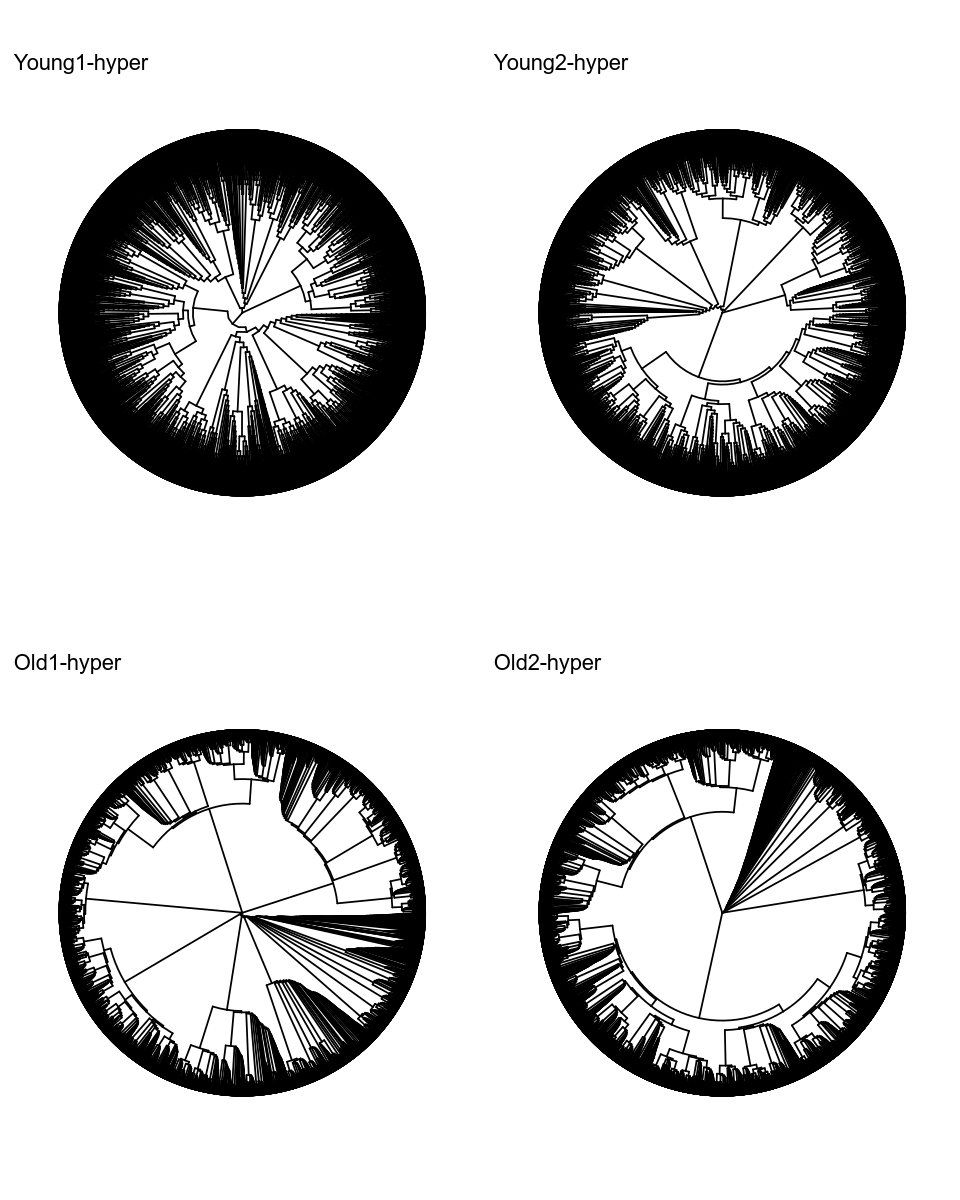

In [144]:
options(repr.plot.width = 8, repr.plot.height = 10, repr.plot.res = 120)
grid.arrange(grobs=plot_trees.hyper,nrow=2)

In [145]:
pdf("../plots/07_nearest_neighbor_tree.y1y2o1o2.trim5.binom.trees.pdf")
grid.arrange(grobs=plot_trees.hyper_dloopb,nrow=2)
dev.off()

png 
  2


Phylogenetic tree with 10051 tips and 10049 internal nodes.

Tip labels:
  AAACAAGCAAACTAAC.1, AAACAAGCACCTCGAC.2, AAACAAGCACTTCAAC.1, AAACCAGGTGCAACGG.2, AAACCAGGTGGATTAG.2, AAACCAGGTTAAAGAC.1, ...

Unrooted; includes branch lengths.

<span style="color: blue;"> Save the tree as newick </br>

In [17]:
write.tree(Young1_BMMC_HSPC_mitoTracing.sensitive_JACnj@TREE@phylo, file = "../output/trees/Young1_BMMC_HSPC_filter-1.newick")
write.tree(Young2_BMMC_HSPC_mitoTracing.sensitive_JACnj@TREE@phylo, file = "../output/trees/Young2_BMMC_HSPC_filter-1.newick")
write.tree(Old1_BMMC_HSPC_mitoTracing.sensitive_JACnj@TREE@phylo, file = "../output/trees/Old1_BMMC_HSPC_filter-1.newick")
write.tree(Old2_BMMC_HSPC_mitoTracing.sensitive_JACnj@TREE@phylo, file = "../output/trees/Old2_BMMC_HSPC_filter-1.newick")

write.tree(trees$Young1@phylo, file = "../output/trees/Young1_BMMC_HSPC_filter-2.newick")
write.tree(trees$Young2@phylo, file = "../output/trees/Young2_BMMC_HSPC_filter-2.newick")
write.tree(trees$Old1@phylo, file = "../output/trees/Old1_BMMC_HSPC_filter-2.newick")
write.tree(trees$Old2@phylo, file = "../output/trees/Old2_BMMC_HSPC_filter-2.newick")

In [ ]:
lab/solexa_weissman/cweng/Projects/Collaborator/Caleb/github_redeem_plus/output/trees/Old2_BMMC_HSPC_filter-2.newick

# Nearest neighborhood analysis

<span style="color: blue;"> Get cell-cell distance from original redeem data across 4 donors </br>

In [4]:
Old1_BMMC_HSPC_redeemr.sensitive_JACnj<-readRDS("/lab/solexa_weissman/cweng/Projects/MitoTracing_Velocity/SecondaryAnalysis/Old1Old2/RDS/Old1_BMMC_HSPC_mitoTracing.sensitive_JACnj_Vassigned_p") %>% convert_mitotracing_redeemR()
Old2_BMMC_HSPC_redeemr.sensitive_JACnj<-readRDS("/lab/solexa_weissman/cweng/Projects/MitoTracing_Velocity/SecondaryAnalysis/Old1Old2/RDS/Old2_BMMC_HSPC_mitoTracing.sensitive_JACnj_Vassigned_p") %>% convert_mitotracing_redeemR()
Young1_BMMC_HSPC_redeemr.sensitive_JACnj<-readRDS("/lab/solexa_weissman/cweng/Projects/MitoTracing_Velocity/SecondaryAnalysis/Old1Old2/RDS/DN4_BMMC_HSPC_mitoTracing.sensitive_JACnj_Vassigned_p") %>% convert_mitotracing_redeemR()
Young2_BMMC_HSPC_redeemr.sensitive_JACnj<-readRDS("/lab/solexa_weissman/cweng/Projects/MitoTracing_Velocity/SecondaryAnalysis/Old1Old2/RDS/DN9_BMMC_HSPC_mitoTracing.sensitive_JACnj_Vassigned_p") %>% convert_mitotracing_redeemR()

In [10]:
mtx.y1.bi<-Young1_BMMC_HSPC_redeemr.sensitive_JACnj@Cts.Mtx.bi[,-which(colnames(Young1_BMMC_HSPC_redeemr.sensitive_JACnj@Cts.Mtx.bi) %in% c("Variants310TC","Variants309CT","Variants9979GA"))]
mtx.y1.bi<-mtx.y1.bi[rowSums(mtx.y1.bi)>=2,]

mtx.y2.bi<-Young2_BMMC_HSPC_redeemr.sensitive_JACnj@Cts.Mtx.bi[,-which(colnames(Young2_BMMC_HSPC_redeemr.sensitive_JACnj@Cts.Mtx.bi) %in% c("Variants310TC","Variants309CT","Variants9979GA"))]
mtx.y2.bi<-mtx.y2.bi[rowSums(mtx.y2.bi)>=2,]

mtx.o1.bi<-Old1_BMMC_HSPC_redeemr.sensitive_JACnj@Cts.Mtx.bi[,-which(colnames(Old1_BMMC_HSPC_redeemr.sensitive_JACnj@Cts.Mtx.bi) %in% c("Variants310TC","Variants309CT","Variants9979GA"))]
mtx.o1.bi<-mtx.o1.bi[rowSums(mtx.o1.bi)>=2,]

mtx.o2.bi<-Old2_BMMC_HSPC_redeemr.sensitive_JACnj@Cts.Mtx.bi[,-which(colnames(Old2_BMMC_HSPC_redeemr.sensitive_JACnj@Cts.Mtx.bi) %in% c("Variants310TC","Variants309CT","Variants9979GA"))]
mtx.o2.bi<-mtx.o2.bi[rowSums(mtx.y1.bi)>=2,]

In [112]:
neighbor.y1.k15 <- compare_neighborhood(mtx.y1.bi, Young1_BMMC_HSPC.mtx.bi.list$var_pass, 15)
neighbor.y2.k15 <- compare_neighborhood(mtx.y2.bi, Young2_BMMC_HSPC.mtx.bi.list$var_pass, 15)
neighbor.o1.k15 <- compare_neighborhood(mtx.o1.bi, Old1_BMMC_HSPC.mtx.bi.list$var_pass, 15)
neighbor.o2.k15 <- compare_neighborhood(mtx.o2.bi, Old2_BMMC_HSPC.mtx.bi.list$var_pass, 15)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.3 GiB”


In [113]:
neighbor.y1.k30 <- compare_neighborhood(mtx.y1.bi, Young1_BMMC_HSPC.mtx.bi.list$var_pass, 30)
neighbor.y2.k30 <- compare_neighborhood(mtx.y2.bi, Young2_BMMC_HSPC.mtx.bi.list$var_pass, 30)
neighbor.o1.k30 <- compare_neighborhood(mtx.o1.bi, Old1_BMMC_HSPC.mtx.bi.list$var_pass, 30)
neighbor.o2.k30 <- compare_neighborhood(mtx.o2.bi, Old2_BMMC_HSPC.mtx.bi.list$var_pass, 30)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.3 GiB”


In [114]:
datatoplot<-rbind(
      data.frame(rank=neighbor.y1.k15[[1]],sample="y1",k="k15",group="edge_rmv"),
      data.frame(rank=neighbor.y1.k15[[2]],sample="y1",k="k15",group="reshuffle"),
      data.frame(rank=neighbor.y2.k15[[1]],sample="y2",k="k15",group="edge_rmv"),
      data.frame(rank=neighbor.y2.k15[[2]],sample="y2",k="k15",group="reshuffle"),
      data.frame(rank=neighbor.o1.k15[[1]],sample="o1",k="k15",group="edge_rmv"),
      data.frame(rank=neighbor.o1.k15[[2]],sample="o1",k="k15",group="reshuffle"),
      data.frame(rank=neighbor.o2.k15[[1]],sample="o2",k="k15",group="edge_rmv"),
      data.frame(rank=neighbor.o2.k15[[2]],sample="o2",k="k15",group="reshuffle"),
    
      data.frame(rank=neighbor.y1.k30[[1]],sample="y1",k="k30",group="edge_rmv"),
      data.frame(rank=neighbor.y1.k30[[2]],sample="y1",k="k30",group="reshuffle"),
      data.frame(rank=neighbor.y2.k30[[1]],sample="y2",k="k30",group="edge_rmv"),
      data.frame(rank=neighbor.y2.k30[[2]],sample="y2",k="k30",group="reshuffle"),
      data.frame(rank=neighbor.o1.k30[[1]],sample="o1",k="k30",group="edge_rmv"),
      data.frame(rank=neighbor.o1.k30[[2]],sample="o1",k="k30",group="reshuffle"),
      data.frame(rank=neighbor.o2.k30[[1]],sample="o2",k="k30",group="edge_rmv"),
      data.frame(rank=neighbor.o2.k30[[2]],sample="o2",k="k30",group="reshuffle")
)

In [119]:
datatoplot$sample <- factor(datatoplot$sample, levels=c("y1","y2","o1","o2"))

Warning message:
“Removed 8 rows containing non-finite values (`stat_boxplot()`).”


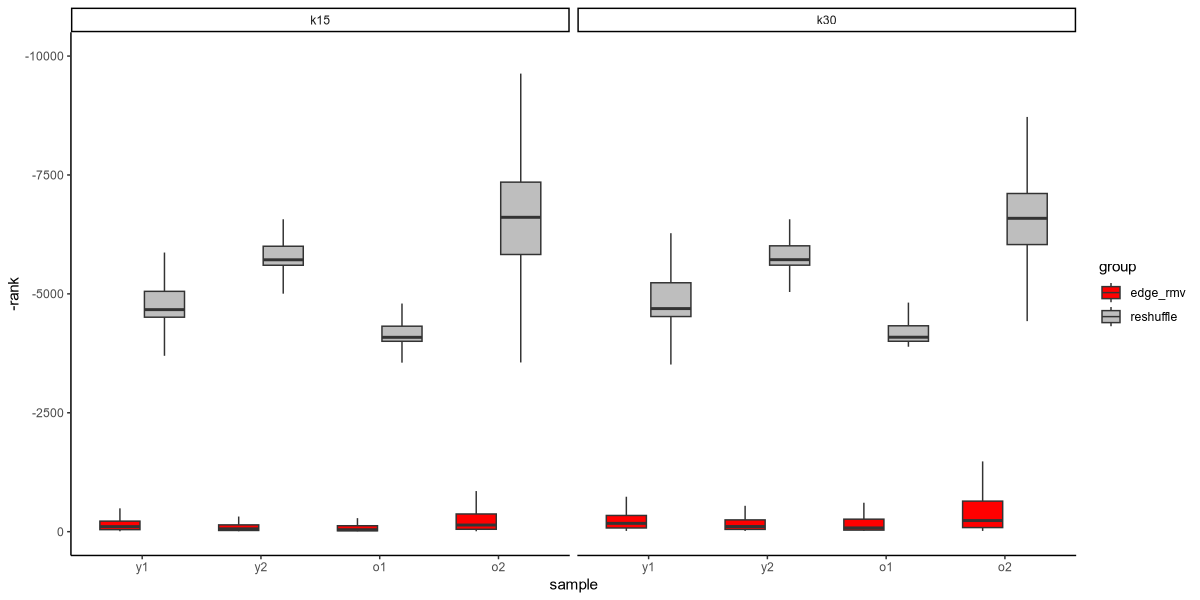

In [120]:
options(repr.plot.width=12, repr.plot.height=6,repr.plot.res=100)
ggplot(datatoplot)+aes(sample,-rank,fill=group)+geom_boxplot(outlier.shape = NA)+facet_grid(.~k)+scale_fill_manual(values=c("red","grey"))+theme_classic()+ylim(0, -10000)

In [117]:
pdf("../plots/07_nearest_neighbo.pdf",width=10)
ggplot(datatoplot)+aes(sample,-rank,fill=group)+geom_boxplot(outlier.shape = NA)+facet_grid(.~k)+scale_fill_manual(values=c("red","grey"))+theme_classic()+ylim(0, -10000)
ggplot(datatoplot)+aes(sample,-rank,fill=group)+geom_boxplot(outlier.shape = NA)+facet_grid(.~k)+scale_fill_manual(values=c("red","grey"))+theme_classic()+ylim(-10000,0)
dev.off()

Warning message:
“Removed 8 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 8 rows containing non-finite values (`stat_boxplot()`).”


png 
  2

In [121]:
summary(neighbor.y1.k15[[1]])
summary(neighbor.y2.k15[[1]])
summary(neighbor.o1.k15[[1]])
summary(neighbor.o2.k15[[1]])

summary(neighbor.y1.k30[[1]])
summary(neighbor.y2.k30[[1]])
summary(neighbor.o1.k30[[1]])
summary(neighbor.o2.k30[[1]])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    8.5    43.0   106.5   188.6   222.0  5276.5 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    8.5    25.5    60.0   167.2   143.0  6835.5 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   8.00   18.50   41.38  182.56  125.00 5171.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    8.5    50.5   140.0   350.5   372.2  8982.0 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   16.0    78.0   175.0   473.8   341.0  6167.5 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   16.0    48.0   108.5   524.0   248.0  7048.5 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   15.5    33.0    79.0   533.7   263.0  5171.0 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   15.5    86.0   234.0   660.3   642.5  8489.0 


----

# Highlight clade

In [32]:
library(phangorn)
## define a function  find expanded clades and to deduplicate clades
IdentityExpandClade<-function(mitoTracing,cladetable,pcut=0.05,ExpandRoof=0.5,ExpandFloor=0.01){
    phylo=mitoTracing@TREE@phylo
    CellN<-nrow(mitoTracing@CellMeta)
    cladetable<-cladetable[order(cladetable$CladeSize),]
    expandclade<-subset(cladetable,p.value<pcut) %>% subset(.,CladeSize<ExpandRoof*CellN & CladeSize>ExpandFloor*CellN )
    idx<-c()
    for (i in 1:nrow(expandclade)){
        if(!any(Ancestors(phylo,expandclade[i,"End"]) %in%  expandclade[,"End"])){
            idx<-c(idx,i)
        }
    }
    return(expandclade[idx,])
}
ExpansionPreprocess<-function(expansion.pvalue,phylo){
    expansion.pvalue$V3<-strsplit(expansion.pvalue$V3,"|",fixed = T) %>% lapply(.,function(x){x[order(x)]}) %>% sapply(.,function(x){paste(x,collapse="|")})
    Phy.string<-Descendants(phylo,node=phylo$edge[,2],type="tips") %>% sapply(.,function(x){paste(phylo$tip.label[x],collapse="|")})
    expansion.pvalue_merge<-expansion.pvalue[match(Phy.string, expansion.pvalue$V3),] %>% cbind(phylo$edge,.) 
    names(expansion.pvalue_merge)<-c("Start","End","Cas","p.value","String")
    expansion.pvalue_merge<-expansion.pvalue_merge[order(expansion.pvalue_merge$p.value),] 
    expansion.pvalue_merge$CladeSize<-strsplit(expansion.pvalue_merge$String,"|",fixed = T) %>% sapply(.,length)
    expansion.pvalue_merge<-expansion.pvalue_merge %>% dplyr::select("Start","End","CladeSize","Cas","p.value","String")
    return(expansion.pvalue_merge)      
}

HighlightClade<-function(tree.data,clade,l="circular",angle=0){
    #-----------------------------------------------------------------------------------------
    tree.data2 <- groupClade(tree.data, c(clade))
    dt<-data.frame(node=c(clade),name=c(clade))
    p<-ggtree(tree.data2,branch.length = "none",aes(color=group),layout = l,open.angle=angle)+geom_cladelab(data=dt,mapping=aes(node=node,label=name))
    return(p)
    }

    AddVariant2ExpansionClade<-function(expansion.pvalue.merge,mitoTracing){
    Variant.assign<-mitoTracing@AssignedVariant$Variant.assign.report %>% tibble::rownames_to_column("Variant") 
    expansion.pvalue.merge_V<-merge(expansion.pvalue.merge[,c("End","CladeSize","p.value")],Variant.assign,by.x="End",by.y="Edge.Assign")
    expansion.pvalue.merge_V<-expansion.pvalue.merge_V[order(expansion.pvalue.merge_V$p.value),]
    return(list(expansion.pvalue.merge=expansion.pvalue.merge,expansion.pvalue.merge_V=expansion.pvalue.merge_V))
}

In [20]:
Old1_BMMC_HSPC_inferfitness<-read.csv("/lab/solexa_weissman/cweng/Projects/MitoTracing_Velocity/SecondaryAnalysis/Reproducibility/Shell_old_expansion/Old1_BMMC_HSPC_filtered_inferfitness.csv")
Old1_fitness<-subset(Old1_BMMC_HSPC_inferfitness,is_leaf=="True")[,c("name","mean_fitness")]
Old1_BMMC_trees_list<-readRDS("/lab/solexa_weissman/cweng/Projects/MitoTracing_Velocity/SecondaryAnalysis/Old1Old2/RDS/Old1_BMMC_trees_list")


Loading required package: scMitoTracing

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘scMitoTracing’”


ERROR: Error in .requirePackage(package): unable to find required package ‘scMitoTracing’


Cell               meanCov  orig.ident    nCount_RNA nFeature_RNA nCount_ATAC
1 AAACAAGCACACTAAG_2 62.17847 SeuratProject 6799       3096         15837      
2 AAACAAGCAGTAATCG_1 11.84634 SeuratProject 4431       1887          2818      
3 AAACAAGCATAAAGGA_2 24.75424 SeuratProject 2202       1357         21897      
4 AAACAAGCATAGGTGC_1 35.41354 SeuratProject 2338       1458         21838      
5 AAACAAGCATTTGGCT_1 13.91563 SeuratProject 1402        981          9466      
6 AAACCAGGTCTAATCA_1 10.34172 SeuratProject 1857       1218          8370      
  nFeature_ATAC nCount_SCT nFeature_SCT SCT.weight ⋯ Sig.pDC1     Sig.ProB1   
1  7727         5043       3089         0.5000000  ⋯ -0.045138770  0.169573501
2  1428         2648       1679         0.4768770  ⋯ -0.046827740 -0.007035251
3 10105         3952       1375         0.4634470  ⋯ -0.008984628 -0.134635533
4  8982         2264       1456         0.9722277  ⋯  0.033098667  0.035289533
5  4420         1578        981         0.4660238  ⋯  0.015085010 -0.071919773
6  3924         1862       1217         0.5258932  ⋯ -0.012450236 -0.031187723
  Sig.PreB1    Sig.B1       Sig.Plasma1  Sig.T1      Sig.CTL1     Sig.NK1    
1  0.054175697 -0.054873067  0.003558243 -0.04370405 -0.009814291 -0.05863317
2  0.035535958 -0.091978120  0.026665648 -0.11481861 -0.192032695 -0.11749480
3 -0.051452566 -0.135396048 -0.044160350  0.03351945 -0.006083351 -0.05569271
4  0.282140813  0.422744867  0.007073249  0.01953373  0.150616914  0.02778333
5 -0.027506166 -0.005560643 -0.020306630  0.17516938  0.407499572  0.23286133
6 -0.004705444  0.030919104  0.034378104 -0.01276470  0.393231574  0.43492580
  Label     mean_fitness
1 Old1_HSPC 0.3776557   
2 Old1_BMMC 0.5719693   
3 Old1_HSPC 0.4927093   
4 Old1_BMMC 0.6974160   
5 Old1_BMMC 0.2922566   
6 Old1_BMMC 0.5047040

In [28]:
FoldCut<-0.01
qCut<-0.01
LossY_Old1_Old2<-readRDS("/lab/solexa_weissman/cweng/Projects/MitoTracing_Velocity/SecondaryAnalysis/Old1Old2/RDS/LossY_Old1_Old2")
Old1_BMMC_LossY<-LossY_Old1_Old2$Old1_BMMC_chr_p %>% filter(Fold<=FoldCut & qvalue<qCut) %>% tibble::rownames_to_column("Cell")
Old1_HSPC_LossY<-LossY_Old1_Old2$Old1_HSPC_chr_p %>% filter(Fold<=FoldCut & qvalue<qCut) %>% tibble::rownames_to_column("Cell") %>% mutate(Cell=gsub("-1","-2",Cell))
Old1_BMMC_HSPC_LossY<-rbind(Old1_BMMC_LossY,Old1_HSPC_LossY)
Old2_BMMC_LossY<-LossY_Old1_Old2$Old2_BMMC_chr_p %>% filter(Fold<=FoldCut & qvalue<qCut) %>% tibble::rownames_to_column("Cell")
Old2_HSPC_LossY<-LossY_Old1_Old2$Old2_HSPC_chr_p %>% filter(Fold<=FoldCut & qvalue<qCut) %>% tibble::rownames_to_column("Cell") %>% mutate(Cell=gsub("-1","-2",Cell))
Old2_BMMC_HSPC_LossY<-rbind(Old2_BMMC_LossY,Old2_HSPC_LossY)
DN1_BMMC_LossY<-LossY_Old1_Old2$Old1_BMMC_chr_p %>% filter(Fold<=FoldCut & qvalue<qCut) %>% tibble::rownames_to_column("Cell")
DN1_HSPC_LossY<-LossY_Old1_Old2$Old1_HSPC_chr_p %>% filter(Fold<=FoldCut & qvalue<qCut) %>% tibble::rownames_to_column("Cell") %>% mutate(Cell=gsub("-1","-2",Cell))
DN1_BMMC_HSPC_LossY<-rbind(DN1_BMMC_LossY,DN1_HSPC_LossY)
Old1_BMMC_HSPC_mitoTracing.sensitive_JACnj@CellMeta<-Old1_BMMC_HSPC_mitoTracing.sensitive_JACnj@CellMeta %>% 
mutate(LossY=ifelse(Cell %in% Translate_simple_RNA2ATAC(DN1_BMMC_HSPC_LossY$Cell),"LossY","")) 
table(Old1_BMMC_HSPC_mitoTracing.sensitive_JACnj@CellMeta$LossY)

The following `from` values were not present in `x`: 3




      LossY 
 9426    93 

In [34]:
Old1_BMMC_filtered.expansion.pvalue<-read.table("/lab/solexa_weissman/cweng/Projects/MitoTracing_Velocity/SecondaryAnalysis/Reproducibility/Shell_old_expansion/Old1_BMMC_filtered.expansion.pvalue")
Old1_HSPC_filtered.expansion.pvalue<-read.table("/lab/solexa_weissman/cweng/Projects/MitoTracing_Velocity/SecondaryAnalysis/Reproducibility/Shell_old_expansion/Old1_HSPC_filtered.expansion.pvalue")
Old1_BMMC.expansion.pvalue<-read.table("/lab/solexa_weissman/cweng/Projects/MitoTracing_Velocity/SecondaryAnalysis/Reproducibility/Shell_old_expansion/Old1_BMMC.expansion.pvalue")
Old1_HSPC.expansion.pvalue<-read.table("/lab/solexa_weissman/cweng/Projects/MitoTracing_Velocity/SecondaryAnalysis/Reproducibility/Shell_old_expansion/Old1_HSPC.expansion.pvalue")
Old1_BMMC_HSPC.expansion.pvalue<-read.table("/lab/solexa_weissman/cweng/Projects/MitoTracing_Velocity/SecondaryAnalysis/Reproducibility/Shell_old_expansion/Old1_BMMC_HSPC.expansion.pvalue")


In [48]:
head(Old1_BMMC_filtered.expansion.pvalue)

V1                        V2          
1 cassiopeia_internal_node0 1.000000e+00
2 TGAGCGGGTACTTCGG_1        1.000000e+00
3 GTTCTTTGTGAGTCCC_1        1.000000e+00
4 cassiopeia_internal_node1 5.616233e-08
5 cassiopeia_internal_node2 1.676165e-04
6 GGCGTAATCGCGATAG_1        1.000000e+00
  V3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [37]:
Old1_BMMC_sg_mitoTracing.sensitive_JACnj<-readRDS("/lab/solexa_weissman/cweng/Projects/MitoTracing_Velocity/SecondaryAnalysis/Old1Old2/RDS/Old1_BMMC_sg_mitoTracing.sensitive_JACnj")
Old1_HSPC_sg_mitoTracing.sensitive_JACnj<-readRDS("/lab/solexa_weissman/cweng/Projects/MitoTracing_Velocity/SecondaryAnalysis/Old1Old2/RDS/Old1_HSPC_sg_mitoTracing.sensitive_JACnj")
Old1_BMMC_trees_list<-readRDS("/lab/solexa_weissman/cweng/Projects/MitoTracing_Velocity/SecondaryAnalysis/Old1Old2/RDS/Old1_BMMC_trees_list")
Old1_HSPC_trees_list<-readRDS("/lab/solexa_weissman/cweng/Projects/MitoTracing_Velocity/SecondaryAnalysis/Old1Old2/RDS/Old1_HSPC_trees_list")

In [57]:
Old1_BMMC_HSPC_mitoTracing.sensitive_JACnj <- readRDS("/lab/solexa_weissman/cweng/Projects/MitoTracing_Velocity/SecondaryAnalysis/Old1Old2/RDS/Old1_BMMC_HSPC_mitoTracing.sensitive_JACnj_Vassigned_p")
Old1_BMMC_HSPC_mitoTracing.sensitive_JACnj <- convert_mitotracing_redeemR(Old1_BMMC_HSPC_mitoTracing.sensitive_JACnj)
Old1_BMMC_HSPC_mitoTracing.sensitive_JACnj@CellMeta <- merge(Old1_BMMC_HSPC_mitoTracing.sensitive_JACnj@CellMeta, Old1_fitness, by.x="Cell",by.y="name")
head(Old1_BMMC_HSPC_mitoTracing.sensitive_JACnj@CellMeta)

Cell               meanCov  orig.ident    nCount_RNA nFeature_RNA nCount_ATAC
1 AAACAAGCACACTAAG_2 62.17847 SeuratProject 6799       3096         15837      
2 AAACAAGCAGTAATCG_1 11.84634 SeuratProject 4431       1887          2818      
3 AAACAAGCATAAAGGA_2 24.75424 SeuratProject 2202       1357         21897      
4 AAACAAGCATAGGTGC_1 35.41354 SeuratProject 2338       1458         21838      
5 AAACAAGCATTTGGCT_1 13.91563 SeuratProject 1402        981          9466      
6 AAACCAGGTCTAATCA_1 10.34172 SeuratProject 1857       1218          8370      
  nFeature_ATAC nCount_SCT nFeature_SCT SCT.weight ⋯ Sig.pDC1     Sig.ProB1   
1  7727         5043       3089         0.5000000  ⋯ -0.045138770  0.169573501
2  1428         2648       1679         0.4768770  ⋯ -0.046827740 -0.007035251
3 10105         3952       1375         0.4634470  ⋯ -0.008984628 -0.134635533
4  8982         2264       1456         0.9722277  ⋯  0.033098667  0.035289533
5  4420         1578        981         0.4660238  ⋯  0.015085010 -0.071919773
6  3924         1862       1217         0.5258932  ⋯ -0.012450236 -0.031187723
  Sig.PreB1    Sig.B1       Sig.Plasma1  Sig.T1      Sig.CTL1     Sig.NK1    
1  0.054175697 -0.054873067  0.003558243 -0.04370405 -0.009814291 -0.05863317
2  0.035535958 -0.091978120  0.026665648 -0.11481861 -0.192032695 -0.11749480
3 -0.051452566 -0.135396048 -0.044160350  0.03351945 -0.006083351 -0.05569271
4  0.282140813  0.422744867  0.007073249  0.01953373  0.150616914  0.02778333
5 -0.027506166 -0.005560643 -0.020306630  0.17516938  0.407499572  0.23286133
6 -0.004705444  0.030919104  0.034378104 -0.01276470  0.393231574  0.43492580
  Label     mean_fitness
1 Old1_HSPC 0.3776557   
2 Old1_BMMC 0.5719693   
3 Old1_HSPC 0.4927093   
4 Old1_BMMC 0.6974160   
5 Old1_BMMC 0.2922566   
6 Old1_BMMC 0.5047040

In [58]:
Old1_BMMC_HSPC_mitoTracing.sensitive_JACnj<-Add_tree_cut(redeemR=Old1_BMMC_HSPC_mitoTracing.sensitive_JACnj,MinCell=75,N=1,prob.cut=0.6,Dumpcut=0)

In [59]:
Old1_BMMC_HSPC_mitoTracing.sensitive_JACnj@CellMeta$Clone_merge<-as.character(Old1_BMMC_HSPC_mitoTracing.sensitive_JACnj@CellMeta$Clone_merge)
Old1_BMMC_HSPC_mitoTracing.sensitive_JACnj@CellMeta$Clone_merge %>% table

.
   1   10   11   12   13   14   15   16   17   18   19    2   20   21   22   23 
1396  171  145  142  141  137  135  135  122  121  120 1279  119  117  116  113 
  24   25   26   27   28   29    3   30   31   32   33   34   35   36   37   38 
 111  102  101   98   94   90  999   88   86   85   85   84   84   78   75   55 
  39    4   40   41   42   43   44   45   46   47   48    5    6    7    8    9 
  53  927   51   51   37   35   32   31   26   22   19  422  258  230  214  179 

In [60]:
Old1_BMMC_filtered.expansion.pvalue.merge<-ExpansionPreprocess(Old1_BMMC_filtered.expansion.pvalue,Old1_BMMC_sg_mitoTracing.sensitive_JACnj@TREE@phylo)
Old1_HSPC_filtered.expansion.pvalue.merge<-ExpansionPreprocess(Old1_HSPC_filtered.expansion.pvalue,Old1_HSPC_sg_mitoTracing.sensitive_JACnj@TREE@phylo)
Old1_BMMC.expansion.pvalue.merge<-ExpansionPreprocess(Old1_BMMC.expansion.pvalue,Old1_BMMC_trees_list$Old1_BMMC_w_jaccard.njtree@phylo)
Old1_HSPC.expansion.pvalue.merge<-ExpansionPreprocess(Old1_HSPC.expansion.pvalue,Old1_HSPC_trees_list$Old1_HSPC_w_jaccard.njtree@phylo)
Old1_BMMC_HSPC.expansion.pvalue.merge<-ExpansionPreprocess(Old1_BMMC_HSPC.expansion.pvalue,Old1_BMMC_HSPC_mitoTracing.sensitive_JACnj@TREE@phylo)

In [61]:

Old1_expand<-IdentityExpandClade(Old1_BMMC_HSPC_mitoTracing.sensitive_JACnj, Old1_BMMC_HSPC.expansion.pvalue.merge,pcut=0.05,ExpandFloor=0.01,)


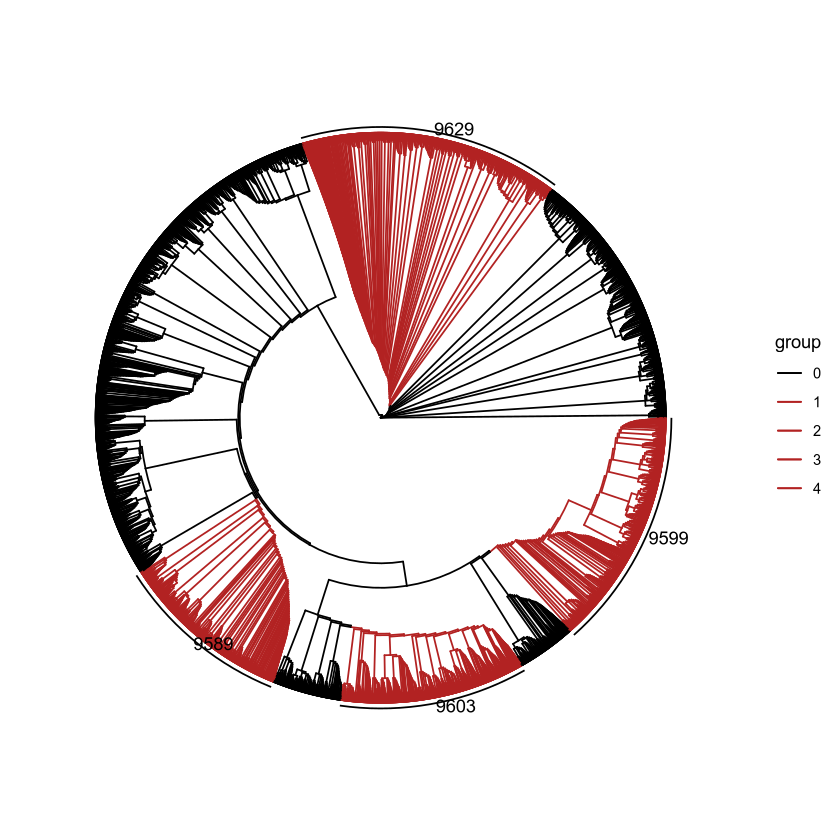

In [62]:
Clone1_nodes<-match(subset(Old1_BMMC_HSPC_mitoTracing.sensitive_JACnj@CellMeta,Clone_merge==1)$Cell,Old1_BMMC_HSPC_mitoTracing.sensitive_JACnj@TREE@phylo$tip.label)
Clone2_nodes<-match(subset(Old1_BMMC_HSPC_mitoTracing.sensitive_JACnj@CellMeta,Clone_merge==2)$Cell,Old1_BMMC_HSPC_mitoTracing.sensitive_JACnj@TREE@phylo$tip.label)
Clone3_nodes<-match(subset(Old1_BMMC_HSPC_mitoTracing.sensitive_JACnj@CellMeta,Clone_merge==3)$Cell,Old1_BMMC_HSPC_mitoTracing.sensitive_JACnj@TREE@phylo$tip.label)
Clone4_nodes<-match(subset(Old1_BMMC_HSPC_mitoTracing.sensitive_JACnj@CellMeta,Clone_merge==4)$Cell,Old1_BMMC_HSPC_mitoTracing.sensitive_JACnj@TREE@phylo$tip.label)


ExpandedClone.clades<-c(mrca.phylo(Old1_BMMC_HSPC_mitoTracing.sensitive_JACnj@TREE@phylo,Clone1_nodes),
                          mrca.phylo(Old1_BMMC_HSPC_mitoTracing.sensitive_JACnj@TREE@phylo,Clone2_nodes),
                          mrca.phylo(Old1_BMMC_HSPC_mitoTracing.sensitive_JACnj@TREE@phylo,Clone3_nodes),
                          mrca.phylo(Old1_BMMC_HSPC_mitoTracing.sensitive_JACnj@TREE@phylo,Clone4_nodes))

HighlightClade(Old1_BMMC_HSPC_mitoTracing.sensitive_JACnj@TREE@treedata, ExpandedClone.clades)+scale_color_manual(values = c("black","firebrick","firebrick","firebrick","firebrick"))

In [75]:
table(Old1_BMMC_HSPC_mitoTracing.sensitive_JACnj@CellMeta$Clade_merge) %>% sort


 9663  9728 10044  9684  9672  9568  9600  9630  9638  9562  9617  9534  9712 
   19    22    26    31    32    35    37    51    51    53    55    75    78 
 9621  9624  9551  9647  9598  9622  9637  9666  9620  9527  9567  9885  9537 
   84    84    85    85    86    88    90    94    98   101   102   111   113 
 9558  9654  9539  9597  9542  9544  9560  9605  9554  9557  9608  9582  9618 
  116   117   119   120   121   122   135   135   137   141   142   145   171 
 9623  9584  9640  9643  9576  9589  9603  9599  9629 
  179   214   230   258   422   927   999  1279  1396 

In [78]:
saveRDS(Old1_BMMC_HSPC_mitoTracing.sensitive_JACnj@CellMeta, "../output/Old1_BMMC_HSPC.cellMeta.rds")

In [116]:
Old1_BMMC_HSPC.cellMeta <- readRDS("../output/Old1_BMMC_HSPC.cellMeta.rds")
rownames(Old1_BMMC_HSPC.cellMeta) <- gsub("_", ".", Old1_BMMC_HSPC.cellMeta$Cell)

In [ ]:
HighlightClade(Old1_BMMC_HSPC_mitoTracing.sensitive_JACnj@TREE@treedata, ExpandedClone.clades)+scale_color_manual(values = c("black","firebrick","firebrick","firebrick","firebrick"))

In [181]:
# Old1
tree1 <- Old1_BMMC_HSPC_mitoTracing.sensitive_JACnj@TREE@treedata
tree2 <- trees$Old1
shared_cells <- intersect(tree1@phylo$tip.label, gsub("[.]", "_", tree2@phylo$tip.label))
head(tree1@phylo$tip.label) # filter1 tree, cell name "_1"
head(tree2@phylo$tip.label) # filter2 tree, cell name ".1"
head(shared_cells) # shared cell, cell name "_1"
length(shared_cells)


[1] "AAACAAGCACACTAAG_2" "AAACAAGCAGTAATCG_1" "AAACAAGCATAAAGGA_2"
[4] "AAACAAGCATAGGTGC_1" "AAACAAGCATTTGGCT_1" "AAACCAGGTCTAATCA_1"

[1] "AAACAAGCAACAGGGA.2" "AAACAAGCACACTAAG.2" "AAACAAGCAGTAATCG.1"
[4] "AAACAAGCATAAAGGA.2" "AAACAAGCATAGGTGC.1" "AAACAAGCATGACAGC.2"

[1] "AAACAAGCACACTAAG_2" "AAACAAGCAGTAATCG_1" "AAACAAGCATAAAGGA_2"
[4] "AAACAAGCATAGGTGC_1" "AAACAAGCATTTGGCT_1" "AAACCAGGTCTAATCA_1"

[1] 7887

[1] "AAACAAGCATAGGTGC.1" "AAACAAGCATTTGGCT.1" "AAACCAGGTCTAATCA.1"
[4] "AAACCGGTCAGTACCC.2" "AAACCGGTCCGCCATG.1" "AAACCGGTCGACATTT.1"

In [185]:
cells_to_highlight <- rownames(Old1_BMMC_HSPC.cellMeta)[which(Old1_BMMC_HSPC.cellMeta$Clade_merge %in% c("9629"))] # .1
head(cells_to_highlight)
tree.data1 <- as_tibble(tree1) %>% mutate(HL=ifelse(label %in% gsub("[.]", "_", cells_to_highlight),"HL","")) %>% as.treedata()
tree.data2 <- as_tibble(tree2) %>% mutate(HL=ifelse(label %in% cells_to_highlight,"HL","")) %>% as.treedata()
as_tibble(tree1) %>% mutate(HL=ifelse(label %in% gsub("[.]", "_", cells_to_highlight),"HL","")) %>% head

[1] "AAACAAGCATAGGTGC.1" "AAACCGGTCCGCCATG.1" "AAACGGTTCTTGTTGG.1"
[4] "AAACTAGTCGCTAATT.2" "AAAGCCAGTTGAGGGT.1" "AAAGCCTAGCCATCAC.1"

parent node branch.length label              HL
1 13814  1    0.4343565     AAACAAGCACACTAAG_2   
2 17967  2    0.3333766     AAACAAGCAGTAATCG_1   
3 16372  3    0.3706790     AAACAAGCATAAAGGA_2   
4 18505  4    0.3037313     AAACAAGCATAGGTGC_1 HL
5 11412  5    0.4839238     AAACAAGCATTTGGCT_1   
6 18591  6    0.3577379     AAACCAGGTCTAATCA_1

In [188]:

p <- ggtree(tree.data1, branch.length = "none", aes(color = HL), layout = l, open.angle = angle) 
p
# p1 <- ggtree(tree.data1 ,branch.length='none',aes(color=HL))
# p2 <- ggtree(tree.data2 ,branch.length='none',aes(color=HL))
# p1+p2 
# library(ape)
# tree.data <- trees$Old1
# cells_to_highlight <- rownames(Old1_BMMC_HSPC.cellMeta)[which(Old1_BMMC_HSPC.cellMeta$Clade_merge %in% c("9629", "9599", "9603", "9589"))] %>% intersect(., )
# head(cells_to_highlight)
# head(as_tibble(tree.data))
# tmp<-subset(Old1_BMMC_HSPC.cellMeta, Clade_merge %in% c(9629, 9599, 9603, 9589))
# dt <- data.frame(node=rownames(tmp), name=tmp$Clade_merge)
# tree.data2<-as_tibble(tree.data) %>% mutate(HL=ifelse(label %in% cells_to_highlight,"HL","")) %>% as.treedata()
# head(tree.data2)
# p <- ggtree(tree.data2,branch.length='none',aes(color=HL))
# p

Warning message in check.graph.layout(tr, trash, layout, layout.params):
“restarting interrupted promise evaluation”


ERROR: Error in eval(expr, envir, enclos): object 'l' not found


In [184]:
HighlightClade

function(tree.data,clade,l="circular",angle=0){
    #-----------------------------------------------------------------------------------------
    tree.data2 <- groupClade(tree.data, c(clade))
    dt<-data.frame(node=c(clade),name=c(clade))
    p<-ggtree(tree.data2,branch.length = "none",aes(color=group),layout = l,open.angle=angle)+geom_cladelab(data=dt,mapping=aes(node=node,label=name))
    return(p)
    }
<bytecode: 0x55f728094270>

In [120]:
head(trees$Old1@phylo$tip.label)
length(trees$Old1@phylo$tip.label)
head(Old1_BMMC_HSPC.cellMeta)
dim(Old1_BMMC_HSPC.cellMeta)
overlapped_cells <- intersect(trees$Old1@phylo$tip.label, rownames(Old1_BMMC_HSPC.cellMeta))
length(overlapped_cells)

[1] "AAACAAGCAACAGGGA.2" "AAACAAGCACACTAAG.2" "AAACAAGCAGTAATCG.1"
[4] "AAACAAGCATAAAGGA.2" "AAACAAGCATAGGTGC.1" "AAACAAGCATGACAGC.2"

[1] 11312

Cell               meanCov  orig.ident    nCount_RNA
AAACAAGCACACTAAG.2 AAACAAGCACACTAAG_2 62.17847 SeuratProject 6799      
AAACAAGCAGTAATCG.1 AAACAAGCAGTAATCG_1 11.84634 SeuratProject 4431      
AAACAAGCATAAAGGA.2 AAACAAGCATAAAGGA_2 24.75424 SeuratProject 2202      
AAACAAGCATAGGTGC.1 AAACAAGCATAGGTGC_1 35.41354 SeuratProject 2338      
AAACAAGCATTTGGCT.1 AAACAAGCATTTGGCT_1 13.91563 SeuratProject 1402      
AAACCAGGTCTAATCA.1 AAACCAGGTCTAATCA_1 10.34172 SeuratProject 1857      
                   nFeature_RNA nCount_ATAC nFeature_ATAC nCount_SCT
AAACAAGCACACTAAG.2 3096         15837        7727         5043      
AAACAAGCAGTAATCG.1 1887          2818        1428         2648      
AAACAAGCATAAAGGA.2 1357         21897       10105         3952      
AAACAAGCATAGGTGC.1 1458         21838        8982         2264      
AAACAAGCATTTGGCT.1  981          9466        4420         1578      
AAACCAGGTCTAATCA.1 1218          8370        3924         1862      
                   nFeature_SCT SCT.weight ⋯ Sig.PreB1    Sig.B1      
AAACAAGCACACTAAG.2 3089         0.5000000  ⋯  0.054175697 -0.054873067
AAACAAGCAGTAATCG.1 1679         0.4768770  ⋯  0.035535958 -0.091978120
AAACAAGCATAAAGGA.2 1375         0.4634470  ⋯ -0.051452566 -0.135396048
AAACAAGCATAGGTGC.1 1456         0.9722277  ⋯  0.282140813  0.422744867
AAACAAGCATTTGGCT.1  981         0.4660238  ⋯ -0.027506166 -0.005560643
AAACCAGGTCTAATCA.1 1217         0.5258932  ⋯ -0.004705444  0.030919104
                   Sig.Plasma1  Sig.T1      Sig.CTL1     Sig.NK1     Label    
AAACAAGCACACTAAG.2  0.003558243 -0.04370405 -0.009814291 -0.05863317 Old1_HSPC
AAACAAGCAGTAATCG.1  0.026665648 -0.11481861 -0.192032695 -0.11749480 Old1_BMMC
AAACAAGCATAAAGGA.2 -0.044160350  0.03351945 -0.006083351 -0.05569271 Old1_HSPC
AAACAAGCATAGGTGC.1  0.007073249  0.01953373  0.150616914  0.02778333 Old1_BMMC
AAACAAGCATTTGGCT.1 -0.020306630  0.17516938  0.407499572  0.23286133 Old1_BMMC
AAACCAGGTCTAATCA.1  0.034378104 -0.01276470  0.393231574  0.43492580 Old1_BMMC
                   mean_fitness Clade_merge Clone_merge
AAACAAGCACACTAAG.2 0.3776557    9582        11         
AAACAAGCAGTAATCG.1 0.5719693    9643        6          
AAACAAGCATAAAGGA.2 0.4927093    9560        15         
AAACAAGCATAGGTGC.1 0.6974160    9629        1          
AAACAAGCATTTGGCT.1 0.2922566    9599        2          
AAACCAGGTCTAATCA.1 0.5047040    9603        3

[1] 9519   37

[1] 7887

In [131]:
head(trees$Old1@phylo$tip.label)
filter1.clade_group <- rep(NA, length(trees$Old1@phylo$tip.label))
names(filter1.clade_group) <- trees$Old1@phylo$tip.label
merge_label <- merge(data.frame(cell=trees$Old1@phylo$tip.label), Old1_BMMC_HSPC.cellMeta[,"Clade_merge", drop=F], by.x='cell', by.y=0, all.x=TRUE) 
rownames(merge_label) <- merge_label$cell
head(merge_label)
head( merge_label[trees$Old1@phylo$tip.label, "Clade_merge"])

[1] "AAACAAGCAACAGGGA.2" "AAACAAGCACACTAAG.2" "AAACAAGCAGTAATCG.1"
[4] "AAACAAGCATAAAGGA.2" "AAACAAGCATAGGTGC.1" "AAACAAGCATGACAGC.2"

cell               Clade_merge
AAACAAGCAACAGGGA.2 AAACAAGCAACAGGGA.2   NA       
AAACAAGCACACTAAG.2 AAACAAGCACACTAAG.2 9582       
AAACAAGCAGTAATCG.1 AAACAAGCAGTAATCG.1 9643       
AAACAAGCATAAAGGA.2 AAACAAGCATAAAGGA.2 9560       
AAACAAGCATAGGTGC.1 AAACAAGCATAGGTGC.1 9629       
AAACAAGCATGACAGC.2 AAACAAGCATGACAGC.2   NA

[1]   NA 9582 9643 9560 9629   NA

[1] "AAACAAGCATAGGTGC.1" "AAACAAGCATTTGGCT.1" "AAACCAGGTCTAATCA.1"
[4] "AAACCGGTCAGTACCC.2" "AAACCGGTCCGCCATG.1" "AAACCGGTCGACATTT.1"

parent node branch.length label             
1 15289  1    0.4457128     AAACAAGCAACAGGGA.2
2 17432  2    0.4230959     AAACAAGCACACTAAG.2
3 20974  3    0.3749642     AAACAAGCAGTAATCG.1
4 21845  4    0.3331476     AAACAAGCATAAAGGA.2
5 21900  5    0.3334642     AAACAAGCATAGGTGC.1
6 16756  6    0.4289686     AAACAAGCATGACAGC.2

node HL
1 1

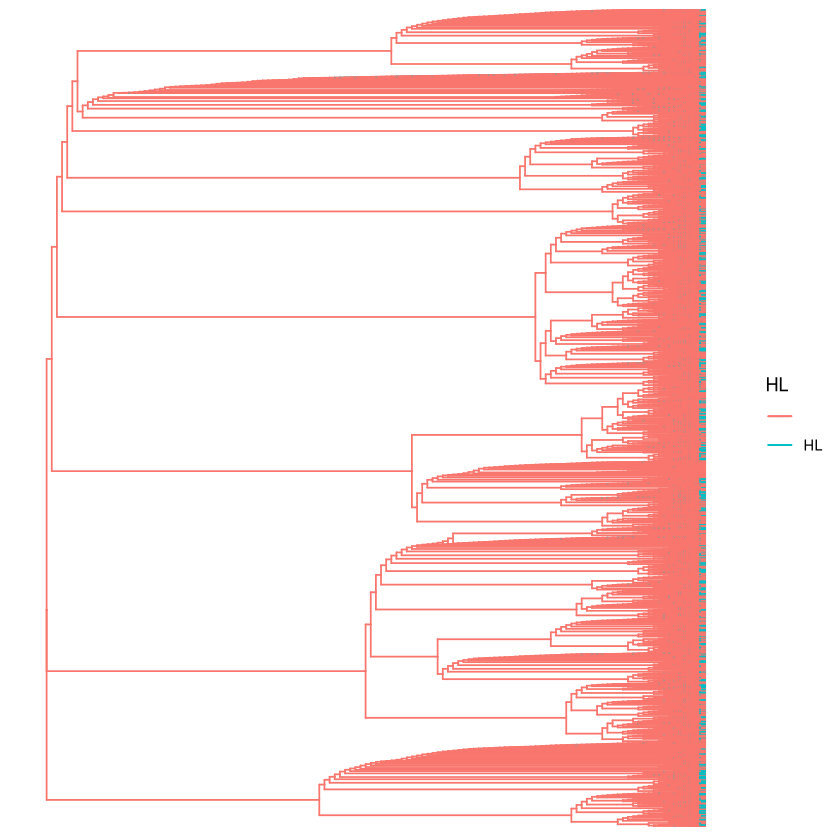

In [158]:
library(ape)
tree.data <- trees$Old1
cells_to_highlight <- rownames(Old1_BMMC_HSPC.cellMeta)[which(Old1_BMMC_HSPC.cellMeta$Clade_merge %in% c("9629", "9599", "9603", "9589"))] %>% intersect(., )
head(cells_to_highlight)
head(as_tibble(tree.data))
tmp<-subset(Old1_BMMC_HSPC.cellMeta, Clade_merge %in% c(9629, 9599, 9603, 9589))
dt <- data.frame(node=rownames(tmp), name=tmp$Clade_merge)
tree.data2<-as_tibble(tree.data) %>% mutate(HL=ifelse(label %in% cells_to_highlight,"HL","")) %>% as.treedata()
head(tree.data2)
p <- ggtree(tree.data2,branch.length='none',aes(color=HL))
p


In [159]:
filter2.dist_mtx <- cophenetic(trees$Old1@phylo)

In [160]:
dim(filter2.dist_mtx)

[1] 11312 11312

In [161]:
filter1.dista_mtx <- cophenetic(Old1_BMMC_HSPC_mitoTracing.sensitive_JACnj@TREE@treedata@phylo)

In [162]:
dim(filter1.dista_mtx)

[1] 9519 9519

In [163]:
filter1.dista_mtx[1:3,1:3]

AAACAAGCACACTAAG_2 AAACAAGCAGTAATCG_1 AAACAAGCATAAAGGA_2
AAACAAGCACACTAAG_2 0.0000000          0.9482067          0.9468242         
AAACAAGCAGTAATCG_1 0.9482067          0.0000000          0.9151527         
AAACAAGCATAAAGGA_2 0.9468242          0.9151527          0.0000000

In [164]:

filter2.dist_mtx[1:3,1:3]

AAACAAGCAACAGGGA.2 AAACAAGCACACTAAG.2 AAACAAGCAGTAATCG.1
AAACAAGCAACAGGGA.2 0.0000000          0.9984031          0.9999482         
AAACAAGCACACTAAG.2 0.9984031          0.0000000          0.9969703         
AAACAAGCAGTAATCG.1 0.9999482          0.9969703          0.0000000

In [167]:
rownames(filter1.dista_mtx) <- gsub("_", ".", rownames(filter1.dista_mtx))
colnames(filter1.dista_mtx) <- gsub("_", ".", colnames(filter1.dista_mtx))
overlap_cells <- intersect(rownames(filter1.dista_mtx), rownames(filter2.dist_mtx))
filter1.mtx <- filter1.dista_mtx[overlap_cells, overlap_cells]
filter2.mtx <- filter2.dist_mtx[overlap_cells, overlap_cells]

In [168]:
cor(filter1.mtx[upper.tri(filter1.mtx)], filter2.mtx[upper.tri(filter2.mtx)], method='spearman')

[1] -0.05846889

In [171]:
tree1 <- Old1_BMMC_HSPC_mitoTracing.sensitive_JACnj@TREE@treedata
tree2 <- trees$Old1
tips_tree1 <- tree1@phylo$tip.label
tips_tree2 <- tree2@phylo$tip.label
pruned_tree1 <- drop.tip(tree1, setdiff(tips_tree1, shared_tips))
pruned_tree2 <- drop.tip(tree2, setdiff(tips_tree2, shared_tips))

ERROR: Error in UseMethod("drop.tip"): no applicable method for 'drop.tip' applied to an object of class "treedata"


In [172]:
tree1_phylo <- tree1@phylo
tree2_phylo <- tree2@phylo
# Extract the tip labels
tips_tree1 <- tree1_phylo$tip.label
tips_tree2 <- tree2_phylo$tip.label
# Identify shared tips
shared_tips <- intersect(tips_tree1, tips_tree2)
# Prune the trees to include only the shared tips
pruned_tree1_phylo <- drop.tip(tree1_phylo, setdiff(tips_tree1, shared_tips))
pruned_tree2_phylo <- drop.tip(tree2_phylo, setdiff(tips_tree2, shared_tips))
# Optionally, if you need to re-create treedata objects
# Assuming the original tree1 and tree2 contain additional data
pruned_tree1 <- treeio::treedata(phylo = pruned_tree1_phylo, data = tree1@data[shared_tips, ])
pruned_tree2 <- treeio::treedata(phylo = pruned_tree2_phylo, data = tree2@data[shared_tips, ])
# Now you can compare the pruned trees, for example using RF distance
rf_distance <- RF.dist(pruned_tree1_phylo, pruned_tree2_phylo)
print(paste("Robinson-Foulds distance for shared tips:", rf_distance))

Warning message in drop.tip.phylo(tree1_phylo, setdiff(tips_tree1, shared_tips)):
“drop all tips of the tree: returning NULL”
Warning message in drop.tip.phylo(tree2_phylo, setdiff(tips_tree2, shared_tips)):
“drop all tips of the tree: returning NULL”


ERROR: Error in validObject(.Object): invalid class “treedata” object: invalid object for slot "phylo" in class "treedata": got class "NULL", should be or extend class "phylo"
